# Book Recommender

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings


from keras.layers import Input, Embedding, Flatten, Dot, Dense, Reshape, Concatenate, Dropout
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import regularizers

from sklearn.model_selection import train_test_split

#warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.
%matplotlib inline is not supported in Databricks.
You can display matplotlib figures using display(). For an example, see https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html

##Import book rating data

In [4]:
#use mount point you previously created when setting up the cluster
# Open and read the file from mounted storage
container = "data/5.Recommenders"
inputFilePath = "/dbfs/mnt/{}/{}".format(container, 'ratings.csv') 
dataset = pd.read_csv(inputFilePath)
dataset.head()

Out[8]: 
 book_id user_id rating
0 1 314 5
1 1 439 3
2 1 588 5
3 1 1169 4
4 1 1185 4

Let's have a look at how many data points we have

In [6]:
dataset.shape

Out[7]: (981756, 3)

Now let us split into train and test set

In [8]:
train, test = train_test_split(dataset, test_size=0.1, random_state=42)
print (train.head())
print(test.head())

book_id user_id rating
719899 7246 22694 4
315161 3155 9388 3
927268 9411 41422 4
589241 5916 11970 3
58784 588 43300 4
 book_id user_id rating
646451 6495 19643 5
614851 6175 8563 4
974393 9920 52110 3
21471 215 33864 5
272540 2728 16587 3

Let's check how many users and items we have

In [10]:
n_users = len(dataset.user_id.unique())
print("Number of users: ", n_users)
n_items = len(dataset.book_id.unique())
print("Number of items: ", n_items)

Number of users: 53424
Number of items: 10000

##Model using dot product
That's equivalent to matrix factorization

In [12]:
item_input = Input(shape=[1], name="Item-Input")
embedding_size = 5 #embedding dimensions
item_embedding = Embedding(input_dim=n_items+1, output_dim=embedding_size, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-items")(item_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(input_dim=n_users+1, output_dim=embedding_size, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

prod = Dot(name="Dot-Product", axes=1)([item_vec, user_vec])
model = Model([user_input, item_input], prod)
model.compile('adam', 'mean_squared_error') # we are trying to approximate a rating, so we use a regression measure: mse

Train the model and save it at the end

In [14]:
nb_epoch = 12
batch_size = 32
history = model.fit([train.user_id, train.book_id], train.rating, 
                    validation_split=0.1,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1)
outputFilePath = "/dbfs/mnt/{}/{}".format(container, 'dotproduct_model.h5')
model.save(outputFilePath)

Train on 795222 samples, validate on 88358 samples
Epoch 1/12

 32/795222 [..............................] - ETA: 7:24:00 - loss: 15.9990
 960/795222 [..............................] - ETA: 15:28 - loss: 15.7124 
 1920/795222 [..............................] - ETA: 8:04 - loss: 16.1030 
 2848/795222 [..............................] - ETA: 5:40 - loss: 15.8816
 3808/795222 [..............................] - ETA: 4:24 - loss: 15.9369
 4768/795222 [..............................] - ETA: 3:39 - loss: 15.9814
 5696/795222 [..............................] - ETA: 3:10 - loss: 15.9200
 6656/795222 [..............................] - ETA: 2:49 - loss: 15.9084
 7552/795222 [..............................] - ETA: 2:34 - loss: 15.8588
 8512/795222 [..............................] - ETA: 2:21 - loss: 15.8417
 9440/795222 [..............................] - ETA: 2:11 - loss: 15.8402
 10400/795222 [..............................] - ETA: 2:03 - loss: 15.8409
 11328/795222 [..............................] - ETA: 1:56 - loss: 15.8485
 12288/795222 [..............................] - ETA: 1:50 - loss: 15.8191
 13248/795222 [..............................] - ETA: 1:45 - loss: 15.8038
 14208/795222 [..............................] - ETA: 1:40 - loss: 15.8134
 15136/795222 [..............................] - ETA: 1:37 - loss: 15.8079
 15776/795222 [..............................] - ETA: 1:35 - loss: 15.8073
 16000/795222 [..............................] - ETA: 1:37 - loss: 15.8027
 16320/795222 [..............................] - ETA: 1:37 - loss: 15.8007
 16512/795222 [..............................] - ETA: 1:39 - loss: 15.7998
 17408/795222 [..............................] - ETA: 1:36 - loss: 15.8035
 18368/795222 [..............................] - ETA: 1:33 - loss: 15.8161
 19328/795222 [..............................] - ETA: 1:30 - loss: 15.8224
 20288/795222 [..............................] - ETA: 1:28 - loss: 15.8268
 21248/795222 [..............................] - ETA: 1:25 - loss: 15.8251
 22208/795222 [..............................] - ETA: 1:23 - loss: 15.8327
 23168/795222 [..............................] - ETA: 1:21 - loss: 15.8392
 24128/795222 [..............................] - ETA: 1:20 - loss: 15.8554
 24928/795222 [..............................] - ETA: 1:19 - loss: 15.8463
 25888/795222 [..............................] - ETA: 1:17 - loss: 15.8480
 26848/795222 [>.............................] - ETA: 1:16 - loss: 15.8440
 27680/795222 [>.............................] - ETA: 1:15 - loss: 15.8342
 28480/795222 [>.............................] - ETA: 1:14 - loss: 15.8444
 29440/795222 [>.............................] - ETA: 1:13 - loss: 15.8429
 30400/795222 [>.............................] - ETA: 1:12 - loss: 15.8414
 31328/795222 [>.............................] - ETA: 1:11 - loss: 15.8340
 32288/795222 [>.............................] - ETA: 1:10 - loss: 15.8252
 33248/795222 [>.............................] - ETA: 1:09 - loss: 15.8261
 34176/795222 [>.............................] - ETA: 1:08 - loss: 15.8257
 35136/795222 [>.............................] - ETA: 1:07 - loss: 15.8222
 36096/795222 [>.............................] - ETA: 1:06 - loss: 15.8234
 36992/795222 [>.............................] - ETA: 1:06 - loss: 15.8257
 37952/795222 [>.............................] - ETA: 1:05 - loss: 15.8309
 38912/795222 [>.............................] - ETA: 1:04 - loss: 15.8295
 39840/795222 [>.............................] - ETA: 1:04 - loss: 15.8277
 40800/795222 [>.............................] - ETA: 1:03 - loss: 15.8258
 41760/795222 [>.............................] - ETA: 1:02 - loss: 15.8244
 42688/795222 [>.............................] - ETA: 1:02 - loss: 15.8226
 43648/795222 [>.............................] - ETA: 1:01 - loss: 15.8153
 44608/795222 [>.............................] - ETA: 1:01 - loss: 15.8107
 45568/795222 [>.............................] - ETA: 1:00 - loss: 15.8109
 46496/795222 [>.............................

Display training and valuation loss over epochs

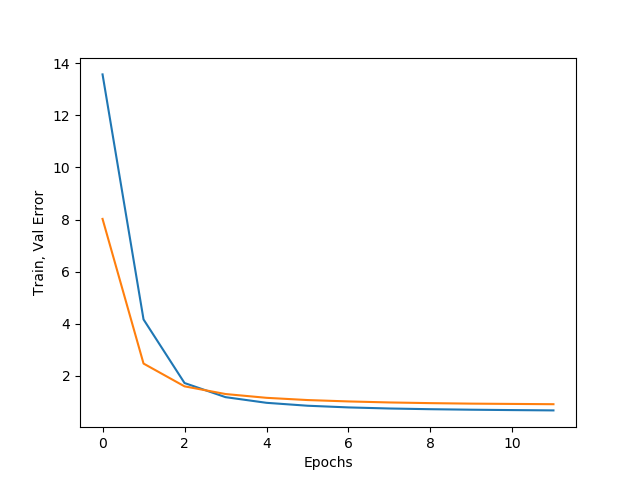

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Train, Val Error")
display()

Evaluate and predict

In [18]:
eval_loss = model.evaluate([test.user_id, test.book_id], test.rating)
print("Evaluation Loss: ", eval_loss)
predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])
# show the first 10 predictions
[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

32/98176 [..............................] - ETA: 10s
 2464/98176 [..............................] - ETA: 2s 
 4864/98176 [>.............................] - ETA: 1s
 7360/98176 [=>............................] - ETA: 1s
 9824/98176 [==>...........................] - ETA: 1s
12256/98176 [==>...........................] - ETA: 1s
14720/98176 [===>..........................] - ETA: 1s
17184/98176 [====>.........................] - ETA: 1s
19584/98176 [====>.........................] - ETA: 1s
22048/98176 [=====>........................] - ETA: 1s
24352/98176 [======>.......................] - ETA: 1s
26784/98176 [=======>......................] - ETA: 1s
29216/98176 [=======>......................] - ETA: 1s
31680/98176 [========>.....................] - ETA: 1s
34144/98176 [=========>....................] - ETA: 1s
36608/98176 [==========>...................] - ETA: 1s
39008/98176 [==========>...................] - ETA: 1s
41472/98176 [===========>..................] - ETA: 1s
43840/98176 [============>.................] - ETA: 1s
46304/98176 [=============>................] - ETA: 1s
48736/98176 [=============>................] - ETA: 1s
51200/98176 [==============>...............] - ETA: 0s
53632/98176 [===============>..............] - ETA: 0s
56032/98176 [================>.............] - ETA: 0s
58496/98176 [================>.............] - ETA: 0s
60928/98176 [=================>............] - ETA: 0s
63328/98176 [==================>...........] - ETA: 0s
65760/98176 [===================>..........] - ETA: 0s
68096/98176 [===================>..........] - ETA: 0s
70112/98176 [====================>.........] - ETA: 0s
72416/98176 [=====================>........] - ETA: 0s
74848/98176 [=====================>........] - ETA: 0s
77280/98176 [======================>.......] - ETA: 0s
79712/98176 [=======================>......] - ETA: 0s
82144/98176 [========================>.....] - ETA: 0s
84544/98176 [========================>.....] - ETA: 0s
87008/98176 [=========================>....] - ETA: 0s
89472/98176 [==========================>...] - ETA: 0s
91808/98176 [===========================>..] - ETA: 0s
94240/98176 [===========================>..] - ETA: 0s
96672/98176 [============================>.] - ETA: 0s
98176/98176 [==============================] - 2s 21us/step
Evaluation Loss: 0.9116050763908079
[4.6234303] 5
[3.9551382] 4
[3.6294892] 3
[4.3497596] 5
[3.2852325] 3
[3.5798793] 3
[3.7937124] 3
[4.563389] 4
[4.1806674] 3
[4.2058268] 5
Out[18]: [None, None, None, None, None, None, None, None, None, None]

To visualize the model, you can use Netron https://lutzroeder.github.io/netron/ in a browser.
Download the h5 file locally and point Netron to it.

## Visualize Embeddings
What are the most relevant latent features that the model has learned for items and users?  
The only layer where the model can learn them is the embedding one, the rest is just a dot product. Let us project those 5d features into 2d space.

In [21]:
# Extract embeddings
book_em = model.get_layer('Item-Embedding')
book_em_weights = book_em.get_weights()[0]

In [22]:
book_em_weights[:5]

Out[21]: 
array([[ 0.04234925, -0.03778834, 0.03114394, -0.01895596, -0.03536317],
 [-1.3750123 , 1.4388065 , -0.9374184 , -1.3208762 , -0.4479044 ],
 [-1.185054 , 1.3482816 , -1.8008676 , -1.2192951 , -0.46729425],
 [-0.6585975 , 1.3389758 , -0.9141986 , -0.9056404 , -1.7476621 ],
 [-1.5405465 , 1.4421169 , -1.006503 , -1.4551831 , 0.54652977]],
 dtype=float32)

Perform PCA on those 5 features.

In [24]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
#sns.relplot(x=pca_result[:,0], y=pca_result[:,1]) #does not work in databricks - old version of seaborn installed
pca_df=pd.DataFrame(pca_result)
pca_df.columns={'PC1', 'PC2'}
display(pca_df)

PC2,PC1
1.454150676727295,1.3487319946289062
-0.15732376277446747,2.402400016784668
-0.22776365280151367,3.1542725563049316
-0.37454089522361755,1.8370410203933716
0.20561030507087708,2.8535592555999756
0.43084704875946045,3.5571205615997314
-0.11696772277355194,2.4160447120666504
-0.013255461119115353,3.274949789047241
0.4796737730503082,3.0978541374206543
-0.16352613270282745,1.918945074081421


Normalize and repeat

In [26]:
book_em_weights = book_em_weights / np.linalg.norm(book_em_weights, axis = 1).reshape((-1, 1))
book_em_weights[0][:10]
np.sum(np.square(book_em_weights[0]))

Out[34]: 1.0

In [27]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
# sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1]) #does not work in databricks
pca_df=pd.DataFrame(pca_result)
pca_df.columns={'PC1', 'PC2'}
display(pca_df)

PC2,PC1
1.0468167066574097,0.2785339951515198
-0.4753093123435974,0.6629919409751892
-0.5191519260406494,0.8633521199226379
-0.42251452803611755,0.4107464551925659
-0.37537041306495667,0.852721095085144
-0.357905775308609,1.0707088708877563
-0.46738025546073914,0.6738254427909851
-0.4809306561946869,0.9378259181976318
-0.36690640449523926,1.0018250942230225
-0.43336912989616394,0.4839378297328949


In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(book_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.004s...
[t-SNE] Computed neighbors for 10001 samples in 0.492s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.034455
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.335419
[t-SNE] Error after 300 iterations: 2.822165

In [29]:
# sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1]) #does not work in databricks
tsne_df=pd.DataFrame(tsne_results)
tsne_df.columns={'PC1', 'PC2'}
display(tsne_df)

PC2,PC1
-8.435515403747559,-7.320657253265381
11.113941192626953,-0.9151638746261597
11.137190818786621,1.3201407194137573
9.024209022521973,1.161317229270935
12.971063613891602,-0.5049661993980408
13.204493522644043,0.19978784024715424
11.37010669708252,-1.2539149522781372
12.473325729370117,0.49900099635124207
13.10608959197998,0.10082437843084335
9.210390090942383,0.9111843109130859


## Make Recommendations
Let us create a "seed" data set to score, containing the user id of interest and 5 book ids

In [31]:
# Creating dataset for making recommendations for the first user
book_data = np.array(list(set(dataset.book_id)))
book_data[:5]

Out[42]: array([1, 2, 3, 4, 5])

In [32]:
user = np.array([1 for i in range(len(book_data))])
user[:5]

Out[43]: array([1, 1, 1, 1, 1])

Now we run the user and book data through the model and extract 5 new books

In [34]:
predictions = model.predict([user, book_data])

predictions = np.array([a[0] for a in predictions])

recommended_book_ids = (-predictions).argsort()[:5]

recommended_book_ids

Out[60]: array([5729, 8604, 7843, 8925, 4942])

In [35]:
# print predicted scores
predictions[recommended_book_ids]

Out[61]: 
array([4.011676 , 3.9908633, 3.9634755, 3.944066 , 3.9142385],
 dtype=float32)

Let us find out what those ids actually represent

In [37]:
inputFilePath = "/dbfs/mnt/{}/{}".format(container, 'books.csv') 
books = pd.read_csv(inputFilePath)
books.head()

Out[68]: 
 ...
0 ...
1 ...
2 ...
3 ...
4 ...

[5 rows x 23 columns]

In [38]:
books[books['id'].isin(recommended_book_ids)].title


Out[73]: 
4941 Wise Blood
5728 Nevermore (Nevermore, #1)
7842 The Returned
8603 Edvard Munch: 1863-1944 (Basic Art)
8924 The Phoenix Project: A Novel About IT, DevOps,...
Name: title, dtype: object

## Deep Recommender
Let the network figure out the relationship between user and items, do not just use a dot product

In [40]:
#concatenate the embeddings
input_vecs = Concatenate()([user_vec, item_vec])
#add a dense layer with regularization
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.2)(x)
#add an output layer
y = Dense(1)(x)

model = Model([user_input, item_input], y)
model.compile('adam', 'mean_squared_error')


In [41]:
#train new model
nb_epoch = 12
batch_size = 32

outputFilePath = "/dbfs/mnt/{}/{}".format(container, 'deep_model.h5')

checkpointer = ModelCheckpoint(filepath=outputFilePath,
                               verbose=1,
                               save_best_only=True)

earlystop = EarlyStopping(monitor='val_loss',
                         patience=5,
                         verbose=1,
                         restore_best_weights=True
                         )

history = model.fit([train.user_id, train.book_id], train.rating,
                    epochs=nb_epoch,
                    #batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[checkpointer, earlystop]).history

Train on 795222 samples, validate on 88358 samples
Epoch 1/12

 32/795222 [..............................] - ETA: 3:14:34 - loss: 23.0176
 672/795222 [..............................] - ETA: 10:16 - loss: 14.6738 
 1408/795222 [..............................] - ETA: 5:23 - loss: 9.1339 
 2144/795222 [..............................] - ETA: 3:51 - loss: 6.4452
 2880/795222 [..............................] - ETA: 3:06 - loss: 5.0852
 3584/795222 [..............................] - ETA: 2:40 - loss: 4.2665
 4288/795222 [..............................] - ETA: 2:23 - loss: 3.7146
 4992/795222 [..............................] - ETA: 2:11 - loss: 3.3309
 5728/795222 [..............................] - ETA: 2:01 - loss: 3.0245
 6464/795222 [..............................] - ETA: 1:53 - loss: 2.7787
 7200/795222 [..............................] - ETA: 1:47 - loss: 2.6009
 7936/795222 [..............................] - ETA: 1:42 - loss: 2.4403
 8640/795222 [..............................] - ETA: 1:38 - loss: 2.3172
 9344/795222 [..............................] - ETA: 1:35 - loss: 2.2052
 10080/795222 [..............................] - ETA: 1:32 - loss: 2.1051
 10784/795222 [..............................] - ETA: 1:29 - loss: 2.0234
 11488/795222 [..............................] - ETA: 1:27 - loss: 1.9554
 12192/795222 [..............................] - ETA: 1:25 - loss: 1.8943
 12928/795222 [..............................] - ETA: 1:24 - loss: 1.8382
 13664/795222 [..............................] - ETA: 1:22 - loss: 1.7862
 14400/795222 [..............................] - ETA: 1:20 - loss: 1.7393
 15136/795222 [..............................] - ETA: 1:19 - loss: 1.6964
 15808/795222 [..............................] - ETA: 1:18 - loss: 1.6627
 16480/795222 [..............................] - ETA: 1:17 - loss: 1.6289
 17152/795222 [..............................] - ETA: 1:16 - loss: 1.5980
 17824/795222 [..............................] - ETA: 1:16 - loss: 1.5688
 18560/795222 [..............................] - ETA: 1:15 - loss: 1.5390
 19232/795222 [..............................] - ETA: 1:14 - loss: 1.5164
 19936/795222 [..............................] - ETA: 1:13 - loss: 1.4927
 20640/795222 [..............................] - ETA: 1:13 - loss: 1.4710
 21312/795222 [..............................] - ETA: 1:12 - loss: 1.4494
 21984/795222 [..............................] - ETA: 1:12 - loss: 1.4315
 22656/795222 [..............................] - ETA: 1:11 - loss: 1.4153
 23328/795222 [..............................] - ETA: 1:11 - loss: 1.3986
 24000/795222 [..............................] - ETA: 1:10 - loss: 1.3812
 24704/795222 [..............................] - ETA: 1:10 - loss: 1.3639
 25408/795222 [..............................] - ETA: 1:09 - loss: 1.3526
 26080/795222 [..............................] - ETA: 1:09 - loss: 1.3372
 26784/795222 [>.............................] - ETA: 1:09 - loss: 1.3225
 27520/795222 [>.............................] - ETA: 1:08 - loss: 1.3088
 28192/795222 [>.............................] - ETA: 1:08 - loss: 1.2953
 28864/795222 [>.............................] - ETA: 1:08 - loss: 1.2821
 29536/795222 [>.............................] - ETA: 1:07 - loss: 1.2727
 30208/795222 [>.............................] - ETA: 1:07 - loss: 1.2625
 30880/795222 [>.............................] - ETA: 1:07 - loss: 1.2508
 31584/795222 [>.............................] - ETA: 1:06 - loss: 1.2402
 32288/795222 [>.............................] - ETA: 1:06 - loss: 1.2308
 33024/795222 [>.............................] - ETA: 1:06 - loss: 1.2226
 33760/795222 [>.............................] - ETA: 1:05 - loss: 1.2136
 34464/795222 [>.............................] - ETA: 1:05 - loss: 1.2055
 35136/795222 [>.............................] - ETA: 1:05 - loss: 1.1983
 35808/795222 [>.............................] - ETA: 1:05 - loss: 1.1911
 36480/795222 [>.............................] - ETA: 1:05 - loss: 1.1826
 37152/795222 [>........

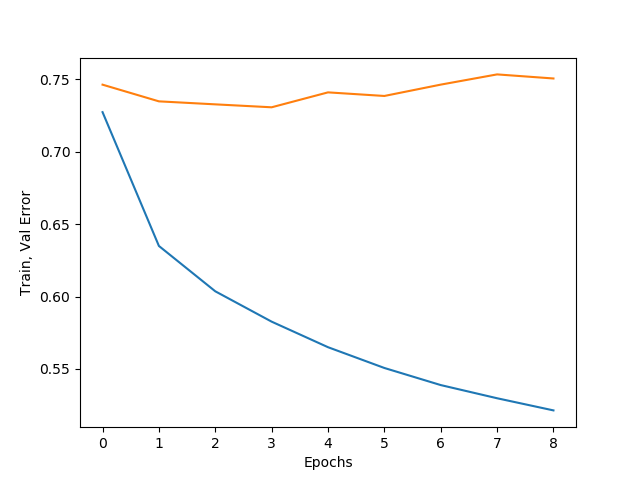

In [42]:
plt.clf()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Train, Val Error")
display()

In [43]:
eval_loss = model.evaluate([test.user_id, test.book_id], test.rating)
print("Evaluation Loss: ", eval_loss)

32/98176 [..............................] - ETA: 10s
 2208/98176 [..............................] - ETA: 2s 
 4448/98176 [>.............................] - ETA: 2s
 6624/98176 [=>............................] - ETA: 2s
 8896/98176 [=>............................] - ETA: 2s
11168/98176 [==>...........................] - ETA: 1s
13376/98176 [===>..........................] - ETA: 1s
15616/98176 [===>..........................] - ETA: 1s
17792/98176 [====>.........................] - ETA: 1s
20032/98176 [=====>........................] - ETA: 1s
22272/98176 [=====>........................] - ETA: 1s
24480/98176 [======>.......................] - ETA: 1s
26656/98176 [=======>......................] - ETA: 1s
28896/98176 [=======>......................] - ETA: 1s
31136/98176 [========>.....................] - ETA: 1s
33312/98176 [=========>....................] - ETA: 1s
35552/98176 [=========>....................] - ETA: 1s
37728/98176 [==========>...................] - ETA: 1s
39872/98176 [===========>..................] - ETA: 1s
42112/98176 [===========>..................] - ETA: 1s
44384/98176 [============>.................] - ETA: 1s
46656/98176 [=============>................] - ETA: 1s
48864/98176 [=============>................] - ETA: 1s
51008/98176 [==============>...............] - ETA: 1s
53248/98176 [===============>..............] - ETA: 1s
55488/98176 [===============>..............] - ETA: 0s
57696/98176 [================>.............] - ETA: 0s
59936/98176 [=================>............] - ETA: 0s
62048/98176 [=================>............] - ETA: 0s
64256/98176 [==================>...........] - ETA: 0s
66464/98176 [===================>..........] - ETA: 0s
68704/98176 [===================>..........] - ETA: 0s
70912/98176 [====================>.........] - ETA: 0s
73088/98176 [=====================>........] - ETA: 0s
75296/98176 [======================>.......] - ETA: 0s
77536/98176 [======================>.......] - ETA: 0s
79776/98176 [=======================>......] - ETA: 0s
82016/98176 [========================>.....] - ETA: 0s
84224/98176 [========================>.....] - ETA: 0s
86432/98176 [=========================>....] - ETA: 0s
88608/98176 [==========================>...] - ETA: 0s
90848/98176 [==========================>...] - ETA: 0s
93088/98176 [===========================>..] - ETA: 0s
95296/98176 [============================>.] - ETA: 0s
97568/98176 [============================>.] - ETA: 0s
98176/98176 [==============================] - 2s 23us/step
Evaluation Loss: 0.732525150732391

Not good! The model clearly overfits the training data, although the mse is still far lower than the previous one.   However, remember the use case: How often will a catalog change, hence re-training be required for new data?

## Add item metadata
We extend the model with data pertaining to the items. This requires numerical embedding of titles

In [46]:
books_subset=books[['id', 'original_title']]
books_subset=books_subset.rename({'id':'book_id'}, axis='columns')

books_subset.head()

Out[87]: 
 ...
0 ...
1 ...
2 ...
3 ...
4 ...

[5 rows x 2 columns]

In [47]:
#create a new dataset by joining the title information
new_dataset=dataset.join(books_subset.set_index('book_id'), on='book_id')
new_dataset.head()
n_metadata=len(new_dataset.original_title.unique())
n_metadata

Out[88]: 9275

Embedding only works on integer vectors. We need to encode the titles.

In [49]:
from keras.preprocessing.text import Tokenizer

titles=np.array(new_dataset.original_title)

t=Tokenizer()
titles=[str(i) for i in new_dataset.original_title]
t.fit_on_texts(titles)

vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_titles = t.texts_to_sequences(titles)

from keras.preprocessing.sequence import pad_sequences
max_length = 10
padded_titles = pad_sequences(encoded_titles, 
                              maxlen=max_length, 
                              padding='post')
padded_titles

Out[89]: 
array([[ 1, 965, 525, ..., 0, 0, 0],
 [ 1, 965, 525, ..., 0, 0, 0],
 [ 1, 965, 525, ..., 0, 0, 0],
 ...,
 [ 1, 63, 20, ..., 0, 0, 0],
 [ 1, 63, 20, ..., 0, 0, 0],
 [ 1, 63, 20, ..., 0, 0, 0]], dtype=int32)

In [50]:
# Join the encoded titles to the dataset
new_dataset=new_dataset.join(pd.DataFrame(padded_titles))
new_dataset.head(10)

Out[90]: 
 book_id user_id rating original_title 0 1 ... 4 5 6 7 8 9
0 1 314 5 The Hunger Games 1 965 ... 0 0 0 0 0 0
1 1 439 3 The Hunger Games 1 965 ... 0 0 0 0 0 0
2 1 588 5 The Hunger Games 1 965 ... 0 0 0 0 0 0
3 1 1169 4 The Hunger Games 1 965 ... 0 0 0 0 0 0
4 1 1185 4 The Hunger Games 1 965 ... 0 0 0 0 0 0
5 1 2077 4 The Hunger Games 1 965 ... 0 0 0 0 0 0
6 1 2487 4 The Hunger Games 1 965 ... 0 0 0 0 0 0
7 1 2900 5 The Hunger Games 1 965 ... 0 0 0 0 0 0
8 1 3662 4 The Hunger Games 1 965 ... 0 0 0 0 0 0
9 1 3922 5 The Hunger Games 1 965 ... 0 0 0 0 0 0

[10 rows x 14 columns]

In [51]:
#split for training
train, test = train_test_split(new_dataset, test_size=0.1, random_state=42)


##Build a new hybrid recommender model
Use embedded item metadata in addition to user, item and rating information

In [53]:
item_input = Input(shape=[1], name="Item-Input")
embedding_size = 5
item_embedding = Embedding(input_dim=n_items+1, output_dim=embedding_size, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-Items")(item_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(input_dim=n_users+1, output_dim=embedding_size, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

metadata_input=Input(shape=[max_length], name="Metadata-Input")
metadata_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_size, name="Metadata-Embedding")(metadata_input)
metadata_vec = Flatten(name="Flatten-Metadata")(metadata_embedding)

In [54]:
# new model with metadata and several regularization techniques to prevent overfitting
input_vecs = Concatenate()([user_vec, item_vec, metadata_vec])
input_vecs = Dropout(0.5)(input_vecs)
x = Dense(128, activation='relu',
          #kernel_regularizer=regularizers.l2(0.01),
          kernel_initializer='random_normal',
          activity_regularizer=regularizers.l1(10e-4) #to prevent overfitting of training data
         )(input_vecs)
#x = Dropout(0.5)(x)
#output layer
y = Dense(1)(x)

new_model = Model([user_input, item_input, metadata_input], y)
new_model.compile('adam', 'mean_squared_error')

In [55]:
## train new model with sampling
nb_epoch = 12
batch_size = 32
outputFilePath = "/dbfs/mnt/{}/{}".format(container, 'hybrid_deep_model.h5')
checkpointer = ModelCheckpoint(filepath=outputFilePath,
                               verbose=1,
                               save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss',
                         patience=5,
                         verbose=1,
                         restore_best_weights=True
                         )

history = new_model.fit([train.user_id, train.book_id, train.iloc[:,4:4+max_length]], train.rating,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[checkpointer, earlystop]).history

Train on 795222 samples, validate on 88358 samples
Epoch 1/12

 32/795222 [..............................] - ETA: 2:08:28 - loss: 15.3390
 640/795222 [..............................] - ETA: 7:27 - loss: 14.6277 
 1280/795222 [..............................] - ETA: 4:15 - loss: 12.9314
 1920/795222 [..............................] - ETA: 3:11 - loss: 10.5285
 2560/795222 [..............................] - ETA: 2:39 - loss: 8.5667 
 3200/795222 [..............................] - ETA: 2:20 - loss: 7.3824
 3808/795222 [..............................] - ETA: 2:08 - loss: 6.5523
 4448/795222 [..............................] - ETA: 1:59 - loss: 5.9120
 5088/795222 [..............................] - ETA: 1:52 - loss: 5.4582
 5696/795222 [..............................] - ETA: 1:46 - loss: 5.1120
 6304/795222 [..............................] - ETA: 1:43 - loss: 4.8103
 6944/795222 [..............................] - ETA: 1:39 - loss: 4.5395
 7584/795222 [..............................] - ETA: 1:36 - loss: 4.3070
 8224/795222 [..............................] - ETA: 1:33 - loss: 4.1143
 8864/795222 [..............................] - ETA: 1:31 - loss: 3.9432
 9472/795222 [..............................] - ETA: 1:29 - loss: 3.7982
 10080/795222 [..............................] - ETA: 1:28 - loss: 3.6683
 10688/795222 [..............................] - ETA: 1:26 - loss: 3.5544
 11328/795222 [..............................] - ETA: 1:25 - loss: 3.4459
 11872/795222 [..............................] - ETA: 1:24 - loss: 3.3600
 12512/795222 [..............................] - ETA: 1:23 - loss: 3.2704
 13120/795222 [..............................] - ETA: 1:22 - loss: 3.1910
 13728/795222 [..............................] - ETA: 1:21 - loss: 3.1179
 14304/795222 [..............................] - ETA: 1:21 - loss: 3.0517
 14848/795222 [..............................] - ETA: 1:21 - loss: 2.9961
 15456/795222 [..............................] - ETA: 1:20 - loss: 2.9362
 16096/795222 [..............................] - ETA: 1:19 - loss: 2.8770
 16704/795222 [..............................] - ETA: 1:19 - loss: 2.8245
 17344/795222 [..............................] - ETA: 1:18 - loss: 2.7746
 17984/795222 [..............................] - ETA: 1:18 - loss: 2.7272
 18560/795222 [..............................] - ETA: 1:17 - loss: 2.6845
 19168/795222 [..............................] - ETA: 1:17 - loss: 2.6416
 19808/795222 [..............................] - ETA: 1:16 - loss: 2.6006
 20448/795222 [..............................] - ETA: 1:16 - loss: 2.5593
 21088/795222 [..............................] - ETA: 1:15 - loss: 2.5240
 21696/795222 [..............................] - ETA: 1:15 - loss: 2.4927
 22336/795222 [..............................] - ETA: 1:14 - loss: 2.4600
 22976/795222 [..............................] - ETA: 1:14 - loss: 2.4327
 23616/795222 [..............................] - ETA: 1:14 - loss: 2.4043
 24256/795222 [..............................] - ETA: 1:13 - loss: 2.3783
 24896/795222 [..............................] - ETA: 1:13 - loss: 2.3537
 25536/795222 [..............................] - ETA: 1:13 - loss: 2.3300
 26176/795222 [..............................] - ETA: 1:12 - loss: 2.3059
 26816/795222 [>.............................] - ETA: 1:12 - loss: 2.2837
 27456/795222 [>.............................] - ETA: 1:12 - loss: 2.2603
 28064/795222 [>.............................] - ETA: 1:11 - loss: 2.2391
 28704/795222 [>.............................] - ETA: 1:11 - loss: 2.2178
 29344/795222 [>.............................] - ETA: 1:11 - loss: 2.1994
 29984/795222 [>.............................] - ETA: 1:11 - loss: 2.1785
 30624/795222 [>.............................] - ETA: 1:10 - loss: 2.1597
 31264/795222 [>.............................] - ETA: 1:10 - loss: 2.1415
 31904/795222 [>.............................] - ETA: 1:10 - loss: 2.1240
 32544/795222 [>.............................] - ETA: 1:10 - loss: 2.1073
 33184/795222 [>.........

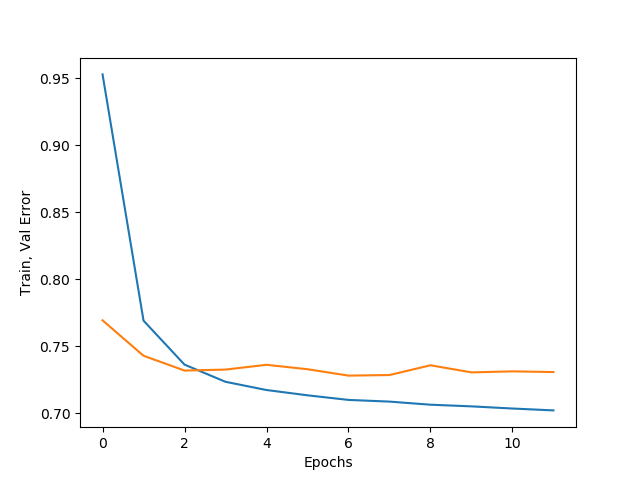

In [56]:
plt.clf()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Train, Val Error")
display()

In [57]:
eval_loss=new_model.evaluate([test.user_id, test.book_id, test.iloc[:, 4:4+max_length]], test.rating)
print("Evaluation loss: ", eval_loss)

32/98176 [..............................] - ETA: 9s
 1856/98176 [..............................] - ETA: 2s
 3680/98176 [>.............................] - ETA: 2s
 5504/98176 [>.............................] - ETA: 2s
 7328/98176 [=>............................] - ETA: 2s
 9184/98176 [=>............................] - ETA: 2s
10656/98176 [==>...........................] - ETA: 2s
12512/98176 [==>...........................] - ETA: 2s
14368/98176 [===>..........................] - ETA: 2s
16160/98176 [===>..........................] - ETA: 2s
18016/98176 [====>.........................] - ETA: 2s
19872/98176 [=====>........................] - ETA: 2s
21728/98176 [=====>........................] - ETA: 2s
23584/98176 [======>.......................] - ETA: 2s
25440/98176 [======>.......................] - ETA: 2s
27296/98176 [=======>......................] - ETA: 1s
29152/98176 [=======>......................] - ETA: 1s
31008/98176 [========>.....................] - ETA: 1s
32832/98176 [=========>....................] - ETA: 1s
34528/98176 [=========>....................] - ETA: 1s
36352/98176 [==========>...................] - ETA: 1s
38176/98176 [==========>...................] - ETA: 1s
40032/98176 [===========>..................] - ETA: 1s
41888/98176 [===========>..................] - ETA: 1s
43744/98176 [============>.................] - ETA: 1s
45568/98176 [============>.................] - ETA: 1s
47424/98176 [=============>................] - ETA: 1s
49248/98176 [==============>...............] - ETA: 1s
51040/98176 [==============>...............] - ETA: 1s
52864/98176 [===============>..............] - ETA: 1s
54688/98176 [===============>..............] - ETA: 1s
56416/98176 [================>.............] - ETA: 1s
58272/98176 [================>.............] - ETA: 1s
60096/98176 [=================>............] - ETA: 1s
61920/98176 [=================>............] - ETA: 1s
63744/98176 [==================>...........] - ETA: 0s
65536/98176 [===================>..........] - ETA: 0s
67360/98176 [===================>..........] - ETA: 0s
69152/98176 [====================>.........] - ETA: 0s
70944/98176 [====================>.........] - ETA: 0s
72768/98176 [=====================>........] - ETA: 0s
74592/98176 [=====================>........] - ETA: 0s
76416/98176 [======================>.......] - ETA: 0s
78240/98176 [======================>.......] - ETA: 0s
80064/98176 [=======================>......] - ETA: 0s
81760/98176 [=======================>......] - ETA: 0s
83552/98176 [========================>.....] - ETA: 0s
85376/98176 [=========================>....] - ETA: 0s
87136/98176 [=========================>....] - ETA: 0s
88928/98176 [==========================>...] - ETA: 0s
90752/98176 [==========================>...] - ETA: 0s
92544/98176 [===========================>..] - ETA: 0s
94304/98176 [===========================>..] - ETA: 0s
96128/98176 [============================>.] - ETA: 0s
97952/98176 [============================>.] - ETA: 0s
98176/98176 [==============================] - 3s 28us/step
Evaluation loss: 0.7332301711058912

Less overfit, better mse overall!

## Now with autoencoder
Let us create a UIR (user-item-rating) matrix from our set of observations

In [60]:
dataset.head()
dataset_pivot=dataset.pivot_table(index='user_id', columns="book_id", values='rating', fill_value=0)
dataset_pivot=dataset_pivot.sort_index(axis=0)
dataset_pivot.head(10)

Out[97]: 
book_id 1 2 3 4 ... 9997 9998 9999 10000
user_id ... 
1 0 0 0 0 ... 0 0 0 0
2 0 0 0 0 ... 0 0 0 0
3 0 0 0 0 ... 0 0 0 0
4 0 0 0 0 ... 0 0 0 0
5 0 0 0 0 ... 0 0 0 0
6 0 0 0 0 ... 0 0 0 0
7 0 0 0 0 ... 0 0 0 0
8 0 0 0 0 ... 0 0 0 0
9 0 0 0 0 ... 0 0 0 0
10 0 0 0 0 ... 0 0 0 0

[10 rows x 10000 columns]

In [61]:
X_train, X_test = train_test_split(dataset_pivot, train_size=0.8, random_state=42)
input_dim=X_train.shape[1]

/databricks/python/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
 FutureWarning)

Build a 1-hidden-layer autoencoder with 128 latent features

In [63]:
input_layer=Input(shape=(input_dim,), name="input_layer")
#hidden layer with regularization terms
x=Dense(128, activation='sigmoid', 
        #kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l1(10e-4),
        kernel_initializer='random_normal',
       #bias_initializer='ones'
       use_bias=False
       )(input_layer)
#output layer
x=Dense(input_dim, activation='linear', 
        use_bias=False,
       #bias_initializer='ones'
       )(x)
model=Model(input_layer, x)
model.compile('adam', 'mse')


In [64]:
nb_epoch = 12
batch_size = 32

outputFilePath = "/dbfs/mnt/{}/{}".format(container, 'autorec_model.h5')
checkpointer = ModelCheckpoint(filepath=outputFilePath,
                               verbose=1,
                               save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss',
                         patience=5,
                         verbose=1,
                         restore_best_weights=True
                         )
history = model.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, earlystop]).history

Train on 42739 samples, validate on 10685 samples
Epoch 1/12

 32/42739 [..............................] - ETA: 5:10 - loss: 2.0759
 192/42739 [..............................] - ETA: 1:05 - loss: 2.0725
 352/42739 [..............................] - ETA: 42s - loss: 2.0604 
 512/42739 [..............................] - ETA: 34s - loss: 2.0366
 672/42739 [..............................] - ETA: 29s - loss: 2.0115
 832/42739 [..............................] - ETA: 26s - loss: 1.9826
 992/42739 [..............................] - ETA: 24s - loss: 1.9578
 1152/42739 [..............................] - ETA: 23s - loss: 1.9346
 1312/42739 [..............................] - ETA: 22s - loss: 1.9094
 1472/42739 [>.............................] - ETA: 21s - loss: 1.8908
 1632/42739 [>.............................] - ETA: 20s - loss: 1.8685
 1792/42739 [>.............................] - ETA: 20s - loss: 1.8450
 1952/42739 [>.............................] - ETA: 19s - loss: 1.8190
 2112/42739 [>.............................] - ETA: 19s - loss: 1.7954
 2272/42739 [>.............................] - ETA: 18s - loss: 1.7783
 2432/42739 [>.............................] - ETA: 18s - loss: 1.7575
 2592/42739 [>.............................] - ETA: 18s - loss: 1.7351
 2752/42739 [>.............................] - ETA: 17s - loss: 1.7148
 2912/42739 [=>............................] - ETA: 17s - loss: 1.6990
 3072/42739 [=>............................] - ETA: 17s - loss: 1.6802
 3232/42739 [=>............................] - ETA: 17s - loss: 1.6642
 3392/42739 [=>............................] - ETA: 17s - loss: 1.6455
 3552/42739 [=>............................] - ETA: 16s - loss: 1.6286
 3712/42739 [=>............................] - ETA: 16s - loss: 1.6141
 3872/42739 [=>............................] - ETA: 16s - loss: 1.5986
 4032/42739 [=>............................] - ETA: 16s - loss: 1.5836
 4192/42739 [=>............................] - ETA: 16s - loss: 1.5690
 4352/42739 [==>...........................] - ETA: 16s - loss: 1.5574
 4512/42739 [==>...........................] - ETA: 15s - loss: 1.5445
 4672/42739 [==>...........................] - ETA: 15s - loss: 1.5310
 4832/42739 [==>...........................] - ETA: 15s - loss: 1.5200
 4992/42739 [==>...........................] - ETA: 15s - loss: 1.5094
 5152/42739 [==>...........................] - ETA: 15s - loss: 1.4952
 5312/42739 [==>...........................] - ETA: 15s - loss: 1.4842
 5472/42739 [==>...........................] - ETA: 15s - loss: 1.4737
 5632/42739 [==>...........................] - ETA: 15s - loss: 1.4611
 5792/42739 [===>..........................] - ETA: 14s - loss: 1.4489
 5952/42739 [===>..........................] - ETA: 14s - loss: 1.4377
 6112/42739 [===>..........................] - ETA: 14s - loss: 1.4277
 6272/42739 [===>..........................] - ETA: 14s - loss: 1.4183
 6432/42739 [===>..........................] - ETA: 14s - loss: 1.4073
 6592/42739 [===>..........................] - ETA: 14s - loss: 1.3973
 6752/42739 [===>..........................] - ETA: 14s - loss: 1.3879
 6912/42739 [===>..........................] - ETA: 14s - loss: 1.3795
 7072/42739 [===>..........................] - ETA: 14s - loss: 1.3711
 7232/42739 [====>.........................] - ETA: 14s - loss: 1.3621
 7392/42739 [====>.........................] - ETA: 14s - loss: 1.3531
 7552/42739 [====>.........................] - ETA: 13s - loss: 1.3439
 7712/42739 [====>.........................] - ETA: 13s - loss: 1.3356
 7872/42739 [====>.........................] - ETA: 13s - loss: 1.3264
 8032/42739 [====>.........................] - ETA: 13s - loss: 1.3193
 8192/42739 [====>.........................] - ETA: 13s - loss: 1.3110
 8352/42739 [====>.........................] - ETA: 13s - loss: 1.3044
 8512/42739 [====>.........................] - ETA: 13s - loss: 1.2956
 8672/42739 [=====>........................] - ETA: 13s - loss: 1.2887
 8832/42739 [=====>...................

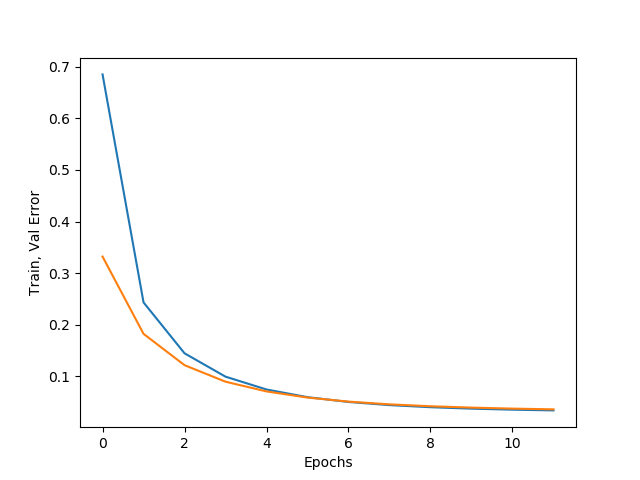

In [65]:
plt.clf()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Train, Val Error")
display()

In [66]:
eval_loss=model.evaluate(X_test, X_test)
print("Evaluation loss: ", eval_loss)

32/10685 [..............................] - ETA: 2s
 384/10685 [>.............................] - ETA: 1s
 768/10685 [=>............................] - ETA: 1s
 1152/10685 [==>...........................] - ETA: 1s
 1536/10685 [===>..........................] - ETA: 1s
 1920/10685 [====>.........................] - ETA: 1s
 2272/10685 [=====>........................] - ETA: 1s
 2624/10685 [======>.......................] - ETA: 1s
 3008/10685 [=======>......................] - ETA: 1s
 3392/10685 [========>.....................] - ETA: 1s
 3744/10685 [=========>....................] - ETA: 0s
 4096/10685 [==========>...................] - ETA: 0s
 4480/10685 [===========>..................] - ETA: 0s
 4864/10685 [============>.................] - ETA: 0s
 5248/10685 [=============>................] - ETA: 0s
 5632/10685 [==============>...............] - ETA: 0s
 6016/10685 [===============>..............] - ETA: 0s
 6400/10685 [================>.............] - ETA: 0s
 6784/10685 [==================>...........] - ETA: 0s
 7168/10685 [===================>..........] - ETA: 0s
 7552/10685 [====================>.........] - ETA: 0s
 7936/10685 [=====================>........] - ETA: 0s
 8320/10685 [======================>.......] - ETA: 0s
 8672/10685 [=======================>......] - ETA: 0s
 9056/10685 [========================>.....] - ETA: 0s
 9440/10685 [=========================>....] - ETA: 0s
 9792/10685 [==========================>...] - ETA: 0s
10144/10685 [===========================>..] - ETA: 0s
10528/10685 [============================>.] - ETA: 0s
10685/10685 [==============================] - 2s 141us/step
Evaluation loss: 0.03626795104509991

It looks good, but let us run some predictions

In [68]:
sample_user=X_test.iloc[99,:]
predictions=model.predict(np.array([sample_user]))
print(predictions[0])
recommended_top10_movieids=(-predictions[0]).argsort()[:10]
print(recommended_top10_movieids)

[-2.2618840e-10 -9.5897075e-13 -1.2671665e-10 ... -5.8717298e-10
 6.5611860e-10 -6.9141376e-10]
[8633 7603 9396 7325 7023 7432 6390 9166 5001 3280]

Let us pick a userid = 4022 that is in test set.

In [70]:
dataset_pivot[dataset_pivot.index==4022]

Out[104]: 
book_id 1 2 3 4 ... 9997 9998 9999 10000
user_id ... 
4022 0 0 0 0 ... 0 0 0 0

[1 rows x 10000 columns]

In [71]:
X_test[X_test.index==4022]

Out[105]: 
book_id 1 2 3 4 ... 9997 9998 9999 10000
user_id ... 
4022 0 0 0 0 ... 0 0 0 0

[1 rows x 10000 columns]

Run some predictions and compare with the actual top rated books

In [73]:
predictions=model.predict(np.array(dataset_pivot[dataset_pivot.index==4022]))
print(predictions[0])
keras_recommended_top_bookids=(-predictions[0]).argsort()[:20]
print(keras_recommended_top_bookids)

[-8.8094374e-14 -2.3472386e-13 4.6619081e-14 ... 2.8464102e-15
 -1.0371541e-12 -5.5219425e-13]
[8633 7432 7325 3733 3966 3280 5069 6612 8560 5244 8561 9759 7603 6093
 7811 9396 4557 5787 7280 9177]

In [74]:
keras_actual_top_bookids=(-np.array(dataset_pivot[dataset_pivot.index==4022])[0]).argsort()[:20]
print(keras_actual_top_bookids)

[7337 2842 3629 6725 3640 7973 4847 5232 6698 2315 2854 3475 3266 5867
 1612 2138 3269 2846 3554 6663]

Not many hits! How's that possible? Because we are forecasting the zeros as well

In [76]:
# precision metrics
def patk (predicted, true, k): 
    patk=len(set(predicted[0:k]).intersection(set(true[0:k])))/k
    return patk

In [77]:
patk(keras_recommended_top_bookids, keras_actual_top_bookids, 20)

Out[110]: 0.0

## With Tensorflow
We customize backpropagation so we can we ignore the 0 values in the test set and only calculate loss on those not 0.

In [79]:
import tensorflow as tf

In [80]:
# let us try with one hidden layer and 1 constant bias
n_nodes_inpl = 10000  
n_nodes_hl1  = 128 
n_nodes_outl = 10000  
hidden_1_layer_vals = {'weights':tf.Variable(tf.random_normal([n_nodes_inpl+1,n_nodes_hl1]))}
output_layer_vals = {'weights':tf.Variable(tf.random_normal([n_nodes_hl1+1,n_nodes_outl])) }

In [81]:
# user with 10000 ratings goes in
input_layer = tf.placeholder('float', [None, 10000])
# add a constant node for bias to the first layer
# it needs to have the same shape as the input layer to concatenate it later
input_layer_const = tf.fill( [tf.shape(input_layer)[0], 1] ,1.0  )
input_layer_concat =  tf.concat([input_layer, input_layer_const], 1)
# multiply output of input_layer wth a weight matrix 
layer_1 = tf.nn.sigmoid(tf.matmul(input_layer_concat,
                                  hidden_1_layer_vals['weights']))
# adding one bias node to the hidden layer
layer1_const = tf.fill( [tf.shape(layer_1)[0], 1] ,1.0  )
layer_concat =  tf.concat([layer_1, layer1_const], 1)
# multiply output of hidden with a weight matrix to get final output
output_layer = tf.matmul( layer_concat,output_layer_vals['weights'])
# output_true shall have the original shape for error calculations
output_true = tf.placeholder('float', [None, 10000])

#this is where we do not train on the zeros
mask=tf.where(tf.equal(input_layer,0.0), tf.zeros_like(input_layer), input_layer) # indices of zero values in the training set (no ratings)
num_train_labels=tf.cast(tf.count_nonzero(mask),dtype=tf.float32) # number of non zero values in the training set
bool_mask=tf.cast(mask,dtype=tf.bool) # boolean mask
output_layer=tf.where(bool_mask, output_layer, tf.zeros_like(output_layer)) # set the output values to zero if corresponding input values are zero

# define our cost function
meansq =    tf.div(tf.reduce_sum(tf.square(tf.subtract(output_layer,input_layer))),num_train_labels)
#rmse = tf.sqrt(meansq)
# define our optimizer
learn_rate = 0.1   # how fast the model should learn
optimizer = tf.train.AdagradOptimizer(learn_rate).minimize(meansq)
        

In [82]:
# initialising variables and starting the session
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
# defining batch size, number of epochs and learning rate
batch_size = 32  # how many images to use together for training
hm_epochs = 100    # how many times to go through the entire dataset
tot_users = X_train.shape[0] # total number of images
n_batches=int(tot_users/batch_size)

In [83]:
from sklearn.metrics import mean_squared_error as MSE

In [84]:
# running the model for a 200 epochs taking 100 users in batches
# total improvement is printed out after each epoch
for epoch in range(hm_epochs):
    epoch_loss = 0    # initializing error as 0
    
    for i in range(n_batches):
        epoch_x = X_train[ i*batch_size : (i+1)*batch_size ]
        _, c = sess.run([optimizer, meansq],
               feed_dict={input_layer: epoch_x, 
               output_true: epoch_x})
        epoch_loss += c
    '''    
    output_train = sess.run(output_layer, feed_dict={input_layer:X_train})
    output_test = sess.run(output_layer, feed_dict={input_layer:X_test})
          
    print('MSE train', MSE(output_train, X_train),'MSE test', MSE(output_test, X_test))   
    '''    
    print('Epoch', epoch, '/', hm_epochs, 'loss:',epoch_loss/n_batches)

Epoch 0 / 100 loss: 36.38846670143613
Epoch 1 / 100 loss: 21.382929049716907
Epoch 2 / 100 loss: 17.637143603692788
Epoch 3 / 100 loss: 15.250065262398023
Epoch 4 / 100 loss: 13.51205104442125
Epoch 5 / 100 loss: 12.17034438415413
Epoch 6 / 100 loss: 11.08146849446529
Epoch 7 / 100 loss: 10.172310627533703
Epoch 8 / 100 loss: 9.400548618116629
Epoch 9 / 100 loss: 8.72998478778739
Epoch 10 / 100 loss: 8.143279432714655
Epoch 11 / 100 loss: 7.625700126783678
Epoch 12 / 100 loss: 7.1608436357662475
Epoch 13 / 100 loss: 6.745007549153732
Epoch 14 / 100 loss: 6.3693600558163075
Epoch 15 / 100 loss: 6.027497900246681
Epoch 16 / 100 loss: 5.716773574316546
Epoch 17 / 100 loss: 5.4314130049966245
Epoch 18 / 100 loss: 5.170379242647007
Epoch 19 / 100 loss: 4.92688911059376
Epoch 20 / 100 loss: 4.7024514136689435
Epoch 21 / 100 loss: 4.493754090195738
Epoch 22 / 100 loss: 4.3008266099829795
Epoch 23 / 100 loss: 4.12117105086198
Epoch 24 / 100 loss: 3.9522468531622867
Epoch 25 / 100 loss: 3.7948849256119033
Epoch 26 / 100 loss: 3.6465746757019772
Epoch 27 / 100 loss: 3.5080941265218715
Epoch 28 / 100 loss: 3.3788235494706513
Epoch 29 / 100 loss: 3.255658325385512
Epoch 30 / 100 loss: 3.139844214168381
Epoch 31 / 100 loss: 3.030827054459504
Epoch 32 / 100 loss: 2.927436619238014
Epoch 33 / 100 loss: 2.8298290917042936
Epoch 34 / 100 loss: 2.736869092693043
Epoch 35 / 100 loss: 2.647922045639838
Epoch 36 / 100 loss: 2.5649714265981416
Epoch 37 / 100 loss: 2.4849791177649623
Epoch 38 / 100 loss: 2.409617603528366
Epoch 39 / 100 loss: 2.338231915793615
Epoch 40 / 100 loss: 2.269263375821185
Epoch 41 / 100 loss: 2.2037680948048495
Epoch 42 / 100 loss: 2.1413586884234728
Epoch 43 / 100 loss: 2.081294610962439
Epoch 44 / 100 loss: 2.0236191146717535
Epoch 45 / 100 loss: 1.9690507111310513
Epoch 46 / 100 loss: 1.916267047057884
Epoch 47 / 100 loss: 1.8661079541518446
Epoch 48 / 100 loss: 1.8176990189746525
Epoch 49 / 100 loss: 1.7711043754990181
Epoch 50 / 100 loss: 1.7268649540367198
Epoch 51 / 100 loss: 1.6836921107958764
Epoch 52 / 100 loss: 1.6420368207751141
Epoch 53 / 100 loss: 1.6025335735930932
Epoch 54 / 100 loss: 1.5647331930948107
Epoch 55 / 100 loss: 1.5279892490039604
Epoch 56 / 100 loss: 1.4918562976273704
Epoch 57 / 100 loss: 1.4577953265847339
Epoch 58 / 100 loss: 1.4253012215711651
Epoch 59 / 100 loss: 1.3931616956821542
Epoch 60 / 100 loss: 1.3624258397670275
Epoch 61 / 100 loss: 1.332366226633055
Epoch 62 / 100 loss: 1.3036594217412927
Epoch 63 / 100 loss: 1.2756478939777456
Epoch 64 / 100 loss: 1.2488018208535647
Epoch 65 / 100 loss: 1.2227223170746802
Epoch 66 / 100 loss: 1.1977935557480386
Epoch 67 / 100 loss: 1.1730977910567313
Epoch 68 / 100 loss: 1.14972378264708
Epoch 69 / 100 loss: 1.1268350468062507
Epoch 70 / 100 loss: 1.1047683716685361
Epoch 71 / 100 loss: 1.08285768259219
Epoch 72 / 100 loss: 1.0619508496914687
Epoch 73 / 100 loss: 1.0419562588079592
Epoch 74 / 100 loss: 1.0218549744103955
Epoch 75 / 100 loss: 1.0024016498514776
Epoch 76 / 100 loss: 0.9839097535314408
Epoch 77 / 100 loss: 0.9656544569865818
Epoch 78 / 100 loss: 0.9481014775565724
Epoch 79 / 100 loss: 0.9306140434987537
Epoch 80 / 100 loss: 0.9142731926079547
Epoch 81 / 100 loss: 0.8980889329861166
Epoch 82 / 100 loss: 0.8824415764614437
Epoch 83 / 100 loss: 0.8668619403343523
Epoch 84 / 100 loss: 0.85171817378577
Epoch 85 / 100 loss: 0.8368772173251552
Epoch 86 / 100 loss: 0.8229038526809841
Epoch 87 / 100 loss: 0.8091831758060258
Epoch 88 / 100 loss: 0.7954177311018165
Epoch 89 / 100 loss: 0.7825985468365949
Epoch 90 / 100 loss: 0.7698121466900637
Epoch 91 / 100 loss: 0.7571449600229884
Epoch 92 / 100 loss: 0.7449294977294707
Epoch 93 / 100 loss: 0.7331702331255437
Epoch 94 / 100 loss: 0.721443754657824
Epoch 95 / 100 loss: 0.7101802970209483
Epoch 96 / 100 loss: 0.6988831726436535
Epoch 97 / 100 loss: 0.6879578725605756
Epoch 98 / 100 loss: 0.6774574387051193
Epoch 99 / 100 loss: 0.6672018876250428

In [85]:
output_train = sess.run(output_layer, feed_dict={input_layer:X_train})
output_test = sess.run(output_layer, feed_dict={input_layer:X_test})
          
print('MSE train', MSE(output_train, X_train),'MSE test', MSE(output_test, X_test))   

# Save the model to disk.
saver=tf.train.Saver()
outputFilePath = "/dbfs/mnt/{}/{}".format(container, 'autorec_tf_model.ckpt')
save_path = saver.save(sess, outputFilePath)
print("Model saved in path: %s" % save_path)

--------------------------------------------------------------------------- 
 UnknownError Traceback (most recent call last)
 <command-2035694585769531> in <module> () 
 7 saver = tf . train . Saver ( ) 
 8 outputFilePath = "/dbfs/mnt/{}/{}" . format ( container , '9.Recommenders/autorec_tf_model.ckpt' ) 
 ----> 9 save_path = saver . save ( sess , outputFilePath ) 
 10 print ( "Model saved in path: %s" % save_path ) 

 /databricks/python/lib/python3.6/site-packages/tensorflow/python/training/saver.py in save (self, sess, save_path, global_step, latest_filename, meta_graph_suffix, write_meta_graph, write_state, strip_default_attrs) 
 1449 all_model_checkpoint_paths = self . last_checkpoints , 
 1450 latest_filename = latest_filename , 
 -> 1451 save_relative_paths=self._save_relative_paths)
 1452 self . _MaybeDeleteOldCheckpoints ( meta_graph_suffix = meta_graph_suffix ) 
 1453 except ( errors . FailedPreconditionError , errors . NotFoundError ) as exc : 

 /databricks/python/lib/python3.6/site-packages/tensorflow/python/training/checkpoint_management.py in update_checkpoint_state_internal (save_dir, model_checkpoint_path, all_model_checkpoint_paths, latest_filename, save_relative_paths, all_model_checkpoint_timestamps, last_preserved_timestamp) 
 235 # file. 
 236 file_io.atomic_write_string_to_file(coord_checkpoint_filename,
 --> 237 text_format.MessageToString(ckpt))
 238 
 239 

 /databricks/python/lib/python3.6/site-packages/tensorflow/python/lib/io/file_io.py in atomic_write_string_to_file (filename, contents, overwrite) 
 434 write_string_to_file ( temp_pathname , contents ) 
 435 try : 
 --> 436 rename ( temp_pathname , filename , overwrite ) 
 437 except errors . OpError : 
 438 delete_file ( temp_pathname ) 

 /databricks/python/lib/python3.6/site-packages/tensorflow/python/lib/io/file_io.py in rename (oldname, newname, overwrite) 
 413 with errors . raise_exception_on_not_ok_status ( ) as status : 
 414 pywrap_tensorflow.RenameFile(
 --> 415 compat.as_bytes(oldname), compat.as_bytes(newname), overwrite, status)
 416 
 417 

 /databricks/python/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py in __exit__ (self, type_arg, value_arg, traceback_arg) 
 526 None , None , 
 527 compat . as_text ( c_api . TF_Message ( self . status . status ) ) , 
 --> 528 c_api.TF_GetCode(self.status.status))
 529 # Delete the underlying status object from memory otherwise it stays alive 
 530 # as there is a reference to status from this from the traceback due to 

 UnknownError : /dbfs/mnt/data/9.Recommenders/checkpoint.tmpb19824b7e1c04f0982377cc822c62e0c; Input/output error

In [86]:
# pick a user
sample_user = X_test[X_test.index==4022]
#get the predicted ratings
predictions = sess.run(output_layer, feed_dict={input_layer:sample_user})

In [87]:
print(predictions[0])
recommended_top20_bookids=(-predictions[0]).argsort()[:20]
print(recommended_top20_bookids)

[0. 0. 0. ... 0. 0. 0.]
[7337 2633 2842 3554 3295 4847 3640 6118 2854 3269 6663 2315 6725 7168
 1612 2336 6698 8592 3266 3123]

In [88]:
actual_top20_bookids=(-np.array(dataset_pivot[dataset_pivot.index==4022])[0]).argsort()[:20]
print(actual_top20_bookids)

[7337 2842 3629 6725 3640 7973 4847 5232 6698 2315 2854 3475 3266 5867
 1612 2138 3269 2846 3554 6663]

Much better predictions!

In [90]:
patk(recommended_top20_bookids, actual_top20_bookids, 20)

Out[124]: 0.65